In [272]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [273]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

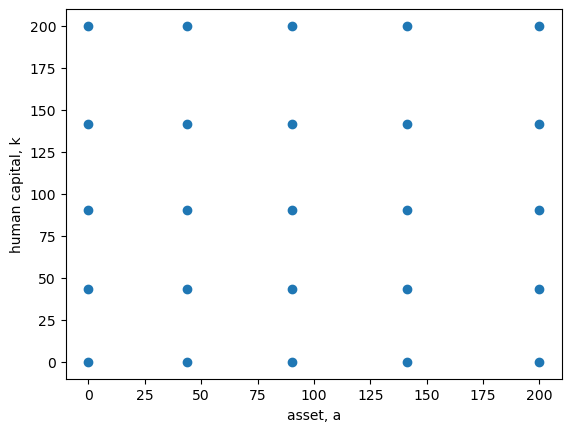

In [267]:
fig, ax = plt.subplots()
a_mesh,s_mesh = np.meshgrid(par.a_grid,par.s_grid,indexing='ij')
ax.scatter(a_mesh,s_mesh)
ax.set(xlabel='asset, a',ylabel='human capital, k');

In [276]:
%time model.solve()

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

In [279]:
%time model.simulate()

CPU times: total: 0 ns
Wall time: 2 ms


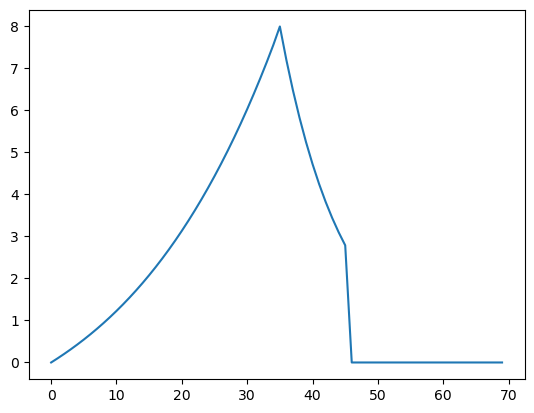

In [291]:
plt.plot(np.arange(par.T),model.sim.s.T)


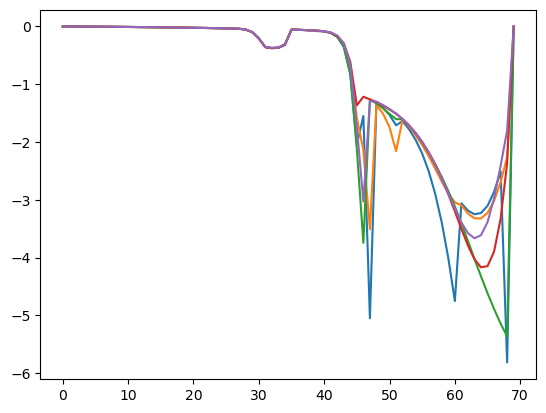

In [252]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 1, 1, i])


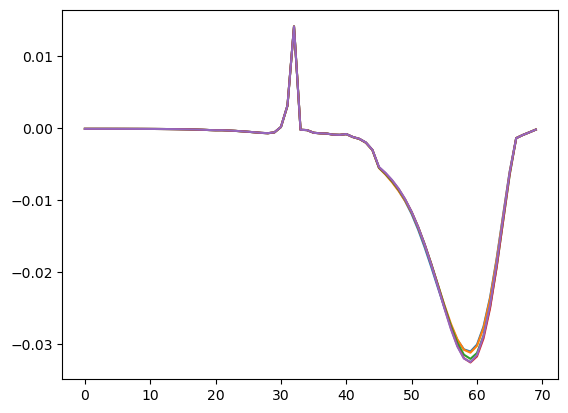

In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 4, 4, i])

In [248]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

array([ 1.68606688e-07,  3.27750938e-07,  4.03241809e-07,  5.97731324e-07,
        7.78199531e-07,  1.08346751e-06,  1.49179941e-06,  1.96114554e-06,
        2.66742355e-06,  3.61209252e-06,  4.80948453e-06,  6.35668779e-06,
        8.39323725e-06,  1.09542932e-05,  1.41753713e-05,  1.81707256e-05,
        2.31201230e-05,  2.91713447e-05,  3.65425408e-05,  2.78873532e-05,
       -2.08289496e-06,  4.12539202e-05,  4.87506277e-05,  5.76463139e-05,
        6.78597478e-05,  7.33871513e-05,  7.76371270e-05,  4.60583080e-05,
       -1.19374581e-04, -7.55490957e-04, -2.98517951e-03, -1.09896839e-02,
        1.43746374e-02,  4.84003192e-05,  3.66743136e-04,  8.14246008e-05,
        3.36083118e-05,  1.46932221e-04,  2.98799290e-05, -1.08330494e-04,
        4.05343483e-04,  2.53004954e-04,  5.12281160e-04,  1.03158641e-03,
        2.37320989e-03,  8.22136778e-04,  9.89269160e-04,  1.20241027e-03,
        1.46694065e-03,  1.77605797e-03,  2.11365025e-03,  2.45569014e-03,
        2.76615468e-03,  

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
C:\Users\B465929\AppData\Local\Temp\ipykernel_2324\20588508.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')
C:\Users\B465929\AppData\Local\Temp\ipykernel_2324\20588508.py:28: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')


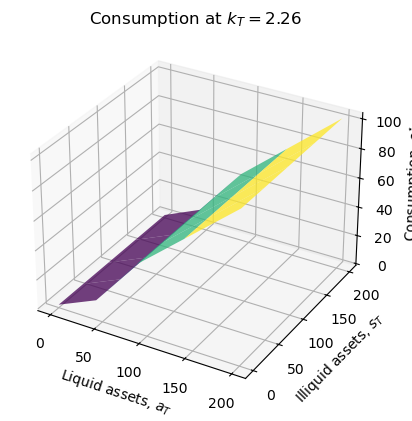

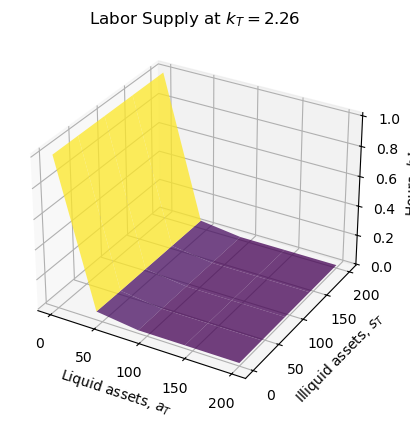

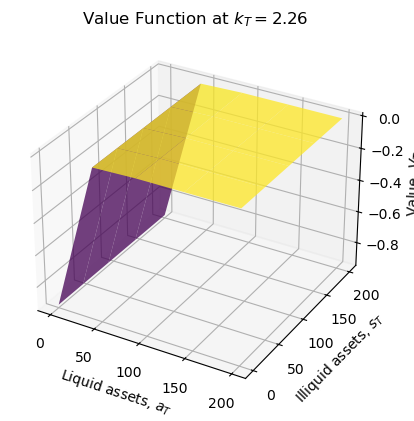

In [225]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
